<a href="https://colab.research.google.com/github/chm231/TRG25/blob/main/Greatcell_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
영재 덕에 알게 된건데 나도 다시 좀 해보니까 신경망을 그냥 MLP로 해도 되거든?
오히려 PFNN보다 잘 돼. 그냥 MLP로 하고 나느 hidden layer 층 개수 64, 64, 64, 64
이렇게 하고 learning rate 점차 감소되게끔 하면 결과 잘 나오더라고.
한번 최대한 간단하게 해서 해봐
'''


In [ ]:
!pip install deepxde

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Compiling model...
Building feed-forward neural network...
'build' took 0.413101 s

'compile' took 3.297552 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [2.19e-02, 2.19e-02, 2.11e+01, 4.98e+02, 2.64e+01, 6.83e-04, 6.83e-04, 1.39e-04, 3.26e+02, 9.68e+01]    [2.19e-02, 2.19e-02, 2.12e+01, 4.98e+02, 2.64e+01, 6.83e-04, 6.83e-04, 1.39e-04, 3.26e+02, 9.68e+01]    []  
1000      [1.86e-01, 1.43e-01, 6.84e+00, 4.22e-01, 6.55e-01, 2.16e-07, 1.34e-05, 1.69e-05, 4.35e+00, 1.28e+01]    [1.51e-01, 1.25e-01, 6.26e+00, 3.64e-01, 5.65e-01, 2.16e-07, 1.34e-05, 1.69e-05, 4.35e+00, 1.28e+01]    []  
2000      [4.62e-02, 2.17e-01, 7.94e+00, 8.36e-01, 8.04e-01, 4.10e-07, 7.45e-06, 5.57e-05, 3.84e+00, 4.62e+00]    [4.37e-02, 1.56e-01, 7.31e+00, 6.94e-01, 6.69e-01, 4.10e-07, 7.45e-06, 5.57e-05,

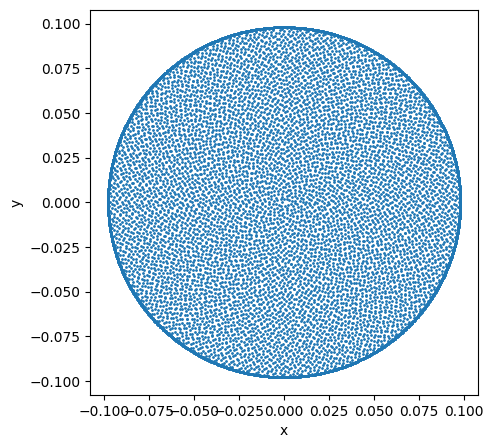

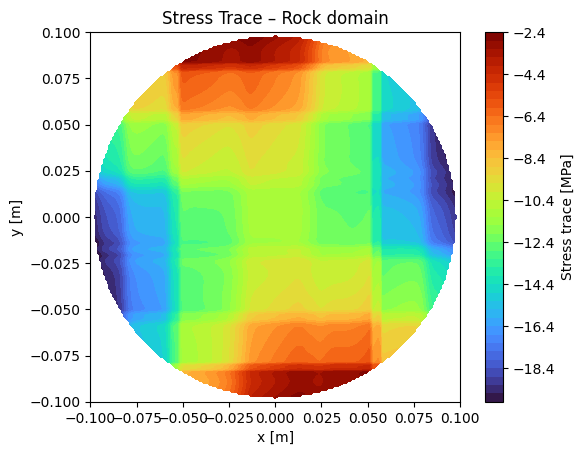

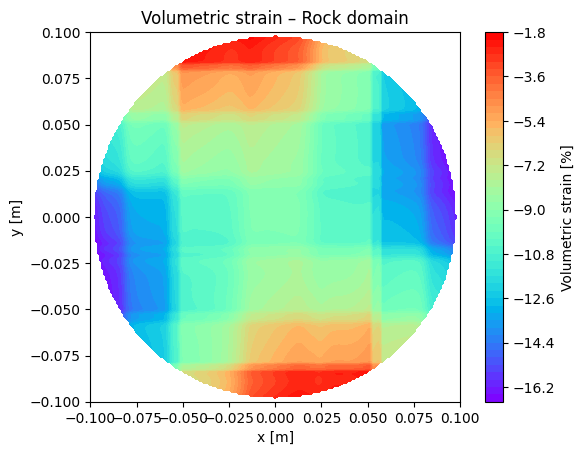

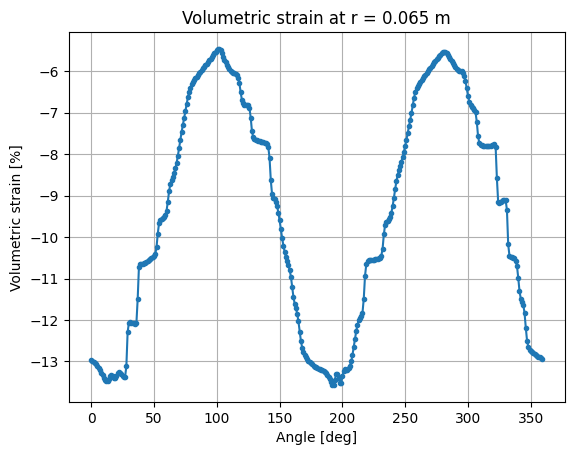

In [ ]:
"""
Plane–strain isotropic disk under piece-wise eccentric edge (PEE–DSS) loading.
PINN implementation with DeepXDE (TensorFlow backend).

• Geometry : solid disk of radius R_disk.
• Boundary  : 32 arc segments, each with prescribed normal traction σ(θ).
              Two support conditions:
                – ‘fixed’ arc  : ux = uy = 0      (≈ −90°)
                – ‘roller’ arc : uy = 0 (ux free) (≈ ±180°)
• Unknowns  : ux, uy, σxx, σyy, σxy  (five-field PFNN).
• Governing : plane-strain linear elasticity + equilibrium (no body force).

"""
import deepxde as dde
import numpy as np
import tensorflow as tf

# ───────────────────────────────────────────────────────────────
# 0. MATERIAL CONSTANTS (dimensional)
# ----------------------------------------------------------------
E   = 83.9          # Young’s modulus (MPa)
nu  = 0.21          # Poisson’s ratio
lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))   # Lamé λ
mu   = E * 0.5 / (1 + nu)                   # Lamé μ

# ───────────────────────────────────────────────────────────────
# 1. GEOMETRY  – disk of radius R_disk
#    Piece-wise external edge loading (32 segments)
# ----------------------------------------------------------------
R_disk = 0.098                                                                  # 원판 반지름 정의 (m)
geom   = dde.geometry.Disk([0.0, 0.0], R_disk)                                  # 중심이 (0,0)이고 반지름 R_disk인 원판(디스크) 기하 생성

# 32개 분할된 원주 구간에 대한 각 θ별 σ_n 값(interpolation 준비)
sigma_pee_16 = np.array(
    [-10.0, -9.95, -7.80, -3.82, -1.00, -1.17, -4.46, -6.64] * 2,
    dtype=np.float32,
)                                                                               # → sigma32 배열 생성, arc_start/arc_end 각도 계산

# Interpolate at mid-segment nodes → 32 values
sigma32           = np.zeros(32, dtype=np.float32)                              # 32개 세그먼트로 보간할 배열 초기화
sigma32[0::2]     = sigma_pee_16                                                # 짝수 인덱스(0,2,4,..)에는 원래 값을 그대로
sigma32[1:-1:2]   = 0.5 * (sigma_pee_16[:-1] + sigma_pee_16[1:])                # 홀수 인덱스(1,3,5,..)에는 이웃 값의 평균
sigma32[31]       = 0.5 * (sigma_pee_16[-1]  + sigma_pee_16[0])                 # 마지막 세그먼트(31)에는 첫·끝 값을 평균

# Start / end angles (deg) for each segment                                     # 각 세그먼트의 시작·끝 각도(도 단위) 계산
arc_start, arc_end = np.empty(32), np.empty(32)
s = -9.375                                                                      # 첫 중심각
for i in range(32):
    arc_start[i] = s
    s += 18.75 if i % 2 == 0 else 3.75                                          # i가 짝수면 큰 호(18.75°), 아니면 작은 호(3.75°)
    arc_end[i] = s

# Pre-store tensors for vectorised lookup                                       # TensorFlow 상수로 변환 (훈련 중 빠른 마스킹용)
ARC_START_T = tf.constant(arc_start, dtype=tf.float32)                          # (32,)
ARC_END_T   = tf.constant(arc_end,   dtype=tf.float32)                          # (32,)
SIGMA32_T   = tf.constant(sigma32,   dtype=tf.float32)                          # (32,)

## 각도 계산 → 조건별로 σ_n 할당 → (N,1) Tensor 반환, sigma_of_angle(…): 경계점 X의 각도(–9.375°~360°)에 맞춰 해당 구간의 σ_n을 반환
"""
    경계점 X(N×2)에 맞춰 정상(노말) 응력 σ_n을 반환.
    1) atan2로 각도(rad→deg) 계산
    2) -9.375° 미만일 땐 +360° wrap
    3) (N,32) boolean mask로 세그먼트 판별
    4) 마스킹된 SIGMA32_T를 합산 → (N,1) 반환
"""
@tf.function
def sigma_of_angle(X: tf.Tensor) -> tf.Tensor:
    ang = tf.math.atan2(X[:, 1], X[:, 0]) * 180.0 / np.pi  # rad → deg         # 1) 각도 계산 (deg)
    ang = tf.where(ang < -9.375, ang + 360.0, ang)                              # 2) wrap-around 처리
    ang = tf.expand_dims(ang, 1)                           # shape (N,1)

    # Boolean mask per segment
    cond      = tf.logical_and(ang >= ARC_START_T, ang < ARC_END_T)             # 3) 각 세그먼트별 필터
    cond_last = tf.logical_and(ang >= ARC_START_T[-1], ang <= ARC_END_T[-1])    # 마지막 세그먼트은 <= arc_end[-1]까지
    cond      = tf.concat([cond[:, :-1], cond_last], axis=1)

    return tf.reduce_sum(tf.where(cond, SIGMA32_T, 0.0), axis=1, keepdims=True) # 4) 조건에 맞는 SIGMA32_T만 남기고 합산

# ───────────────────────────────────────────────────────────────
# 2. PDE RESIDUAL  (equilibrium + Hooke consistency)
# ----------------------------------------------------------------
def pde(x, y):
    """
    x: (N,2) 입력 좌표,
    y: (N,5) NN 예측 [ux, uy, σxx, σyy, σxy]
    반환: [mom_x, mom_y, σxx_th-σxx, σyy_th-σyy, σxy_th-σxy]
    """
    # 변형률 Exx, Eyy, Exy ← 자동미분
    # 이론적 응력 Sxx_th, Syy_th, Sxy_th ← Hooke 법칙
    # NN이 예측한 응력 Sxx, Syy, Sxy ← y[:,2:5]
    # 평형방정식 mom_x, mom_y ← ∂σ_xx/∂x + ∂σ_xy/∂y 등

    # Strain components (automatic differentiation)
    Exx = dde.grad.jacobian(y, x, i=0, j=0)                                     # 1) 변형률 계산 (automatic differentiation)
    Eyy = dde.grad.jacobian(y, x, i=1, j=1)
    Exy = 0.5 * (dde.grad.jacobian(y, x, i=0, j=1) +                            # u_y + v_x 의 평균
                 dde.grad.jacobian(y, x, i=1, j=0))

    # Hooke law (plane strain)                                                  # 2) Hooke 법칙 (plane-strain)
    Sxx_th = (2 * mu + lmbd) * Exx + lmbd * Eyy
    Syy_th = (2 * mu + lmbd) * Eyy + lmbd * Exx
    Sxy_th = 2 * mu * Exy

    # Network-predicted stresses                                                # 3) NN이 예측한 응력
    Sxx, Syy, Sxy = y[:, 2:3], y[:, 3:4], y[:, 4:5]

    # Equilibrium (div σ = 0)                                                  # 4) 평형 방정식(div σ = 0) 잔여식
    Sxx_x = dde.grad.jacobian(y, x, i=2, j=0)                                   # ∂σxx/∂x
    Sxy_y = dde.grad.jacobian(y, x, i=4, j=1)                                   # ∂σxy/∂y
    Sxy_x = dde.grad.jacobian(y, x, i=4, j=0)                                   # ∂σxy/∂x
    Syy_y = dde.grad.jacobian(y, x, i=3, j=1)                                   # ∂σyy/∂y

    mom_x = Sxx_x + Sxy_y           # σ_xx,x + σ_xy,y = 0, x-방향 평형
    mom_y = Sxy_x + Syy_y           # σ_xy,x + σ_yy,y = 0, y-방향 평형

    # Residual list (length 5)
    return [mom_x, mom_y,
            Sxx_th - Sxx, Syy_th - Syy, Sxy_th - Sxy]                           # 5) residual 리스트 반환

'''
역학 방정식:
  평형 조건 (div σ = 0)
  Hooke 일관성 (이론식 σ_th와 NN 출력 σ_diff residual)
출력: 길이 5의 residual 리스트
'''

# ───────────────────────────────────────────────────────────────
# 3. BOUNDARY CONDITIONS
# ----------------------------------------------------------------
tol_deg = 5.0                                                                   # 허용 각도 오차 (deg) You can manipulate this values
def bc_fixed(X, on_b):                                                          # –90° 부근 고정 BC: ux=uy=0
    """
    X: (2,) 좌표, on_b: 경계점 여부(bool)
    반환 True일 때 Dirichlet u=0 적용
    """
    return on_b and abs(np.rad2deg(np.arctan2(X[1], X[0])) + 90.0) < tol_deg    # atan2로 도 단위 각도 계산

def bc_roller(X, on_b):                                                         # ±180° 부근 롤러 BC: uy=0
    return on_b and abs(abs(np.rad2deg(np.arctan2(X[1], X[0]))) - 180.0) < tol_deg  # –90° ± tol 범위에 있으면 True, |θ| ≈ 180° ± tol 범위

bc_fixed_u  = dde.icbc.DirichletBC(geom, lambda _: 0.0, bc_fixed , component=0) # –90° 부근에서 ux=uy=0 (fixed)
bc_fixed_v  = dde.icbc.DirichletBC(geom, lambda _: 0.0, bc_fixed , component=1)
bc_roller_v = dde.icbc.DirichletBC(geom, lambda _: 0.0, bc_roller, component=1) # ±180° 부근에서 uy=0 (roller)

# --- Traction (Operator) BCs on the entire boundary ----------------
def traction_x(X, y_out, _):                                                    # OperatorBC: traction BC (σ·n = σ_n)
    nx = X[:, 0:1] / R_disk                                                     # x-성분 노말 벡터
    ny = X[:, 1:2] / R_disk                                                     # y-성분 노말 벡터

    Sxx, Sxy = y_out[:, 2:3], y_out[:, 4:5]                                     # 예측 σxx, σxy
    tx       = Sxx * nx + Sxy * ny                                              # σ·n → x–component
    sigma_n  = sigma_of_angle(X)                                                # 목표 수직 응력
    return tx - sigma_n * nx

def traction_y(X, y_out, _):
    nx = X[:, 0:1] / R_disk
    ny = X[:, 1:2] / R_disk

    Syy, Sxy = y_out[:, 3:4], y_out[:, 4:5]
    ty       = Sxy * nx + Syy * ny                                              # σ·n → y–component
    sigma_n  = sigma_of_angle(X)
    return ty - sigma_n * ny

# 전 구간(Operator) traction BCs
bc_trac_x = dde.icbc.OperatorBC(geom, traction_x, lambda _, on_b: on_b)         # 경계 전체 적용
bc_trac_y = dde.icbc.OperatorBC(geom, traction_y, lambda _, on_b: on_b)
bcs = [bc_fixed_u, bc_fixed_v, bc_roller_v, bc_trac_x, bc_trac_y]

'''
DirichletBC: 특정 호(arc)에서 변위 고정
OperatorBC: 경계 전체에서 σ·n – σ_n = 0 조건 (외력 매칭)
'''

# ───────────────────────────────────────────────────────────────
# 4. DATASET(학습용 데이터셋 구성)
#  num_domain: 도메인 내부 collocation 점 개수
#  num_boundary: 경계 내 collocation 점 개수
#  num_test: 테스트용 collocation 점 개수
# ----------------------------------------------------------------
data = dde.data.PDE(
    geom,                                                                       # ① 기하(원판) 객체
    pde,                                                                        # ② PDE 잔여식 함수
    bcs,                                                                        # ③ 경계 조건 리스트
    num_domain   = 8000,                                                        # ④ 내부 collocation 점 개수
    num_boundary = 1600,                                                        # ⑤ 경계 collocation 점 개수
    num_test     = 2000                                                         # ⑥ 검증용(test) 점 개수
)

# ───────────────────────────────────────────────────────────────
# 5. NETWORK (PFNN: Parameter-free NN in DeepXDE) : 신경망 모델 정의
# 입력: (x,y)->2차원
# PFNN: Parameter-Free NN 구조, 5개의 출력(ux,uy,σxx, σyy, σxy)
# 활성함수: tanh
# ----------------------------------------------------------------
layer_size = [2] + [[80]*5]*5 + [5]                                             # 1) 각 층의 노드 수 배열 정의 / [입력 차원=2] → [80노드×5층을 5블록 반복] → [출력 차원=5]
net = dde.nn.PFNN(layer_size, activation="tanh", kernel_initializer="Glorot uniform")
                                                                                # 2) PFNN 네트워크 생성
                                                                                #    - PFNN: Parameter-Free Neural Network (깊은 블록 구조)
                                                                                #    - activation: tanh, initialize(가중치 초기화 방식): Glorot uniform
# ───────────────────────────────────────────────────────────────
# 6. TRAINING : 모델 컴파일 및 학습
# loss_weights:
#   PDE residual 5개
#   Dirichlet BC 3개
#   Traction BC 2개 (가중치 10×)
# optimizer: Adam, 학습률 1e-3
# iterations: 20,000 (필요시 더 증가)
# ----------------------------------------------------------------
model = dde.Model(data, net)                                                    # 1) 모델 객체 생성: data + net

# Weighted losses: 5 PDE + 3 Dirichlet + 2 traction components                  # 2) 손실 가중치 설정 (리스트 순서 = [5 PDE, 3 Dirichlet, 2 Traction])
loss_weights = [1, 1, 1, 1, 1,                                                  # PDE 잔여식 5개
                1, 1, 1,                                                        # Dirichlet BC  ux=0, uy=0, uy=0
                10, 10]                                                         # Traction BC (σ·n 잔여식) — 더 강하게 학습

model.compile("adam", lr=1e-3, loss_weights=loss_weights)                       # 3) 컴파일: 옵티마이저, 학습률, 손실 가중치 지정
model.train(iterations=20000)                                                   # 최적화 알고리즘: adam / 학습률 : 1e-3
# model.train(iterations=20000): Try iterations until 100000                    # 4) 학습 수행

# ───────────────────────────────────────────────────────────────
# 7. 학습 데이터 분포 시각화
# 학습에 사용된 도메인, 경계점 산포 확인
# ───────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
plt.scatter(data.train_x[:,0], data.train_x[:,1], s = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# ───────────────────────────────────────────────────────────────
# 8. 예측 결과 후처리 및 컨투어 플롯
#
# ───────────────────────────────────────────────────────────────

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 재료 상수 (MPa 단위)
E, nu = 83.9, 0.21
lmbd = nu / ((1 + nu) * (1 - 2 * nu)) * E
mu   = 0.5 / (1 + nu) * E

#격자생성
R_out  = 0.100                                                                  # 그리드 외곽 반지름
R_rock = 0.098                                                                  # 모델 학습 원판 반지름 (=geom에서 사용)
Ngrid  = 200

x_vals = np.linspace(-R_out, R_out, Ngrid)
y_vals = np.linspace(-R_out, R_out, Ngrid)                                      # x_vals, y_vals 로 200×200 포인트를 균등 분할한 뒤, np.meshgrid 로 2D 격자 배열 X, Y 생성,
X, Y   = np.meshgrid(x_vals, y_vals)                                            # 격자 전체는 [-0.1,0.1]×[-0.1,0.1] 영역을 커버

#모델 예측용 점 배열 준비
grid_pts = np.column_stack([X.flatten(), Y.flatten()]).astype(np.float32)       # X.ravel(), Y.ravel() 로 1차원 벡터화한 뒤 (Ngrid^2,2) 형태로 쌓아 모델 입력으로 사용

#PINN 예측 및 stress trace 계산
pred       = model.predict(grid_pts)                                            # shape (40000,5): [ux, uy, σxx, σyy, σxy]
trace      = pred[:, 2] + pred[:, 3]                                            # σ_trace = σxx + σyy
grid_trace = trace.reshape(X.shape)                                             # 다시 200×200 격자 모양으로 복원

#원판 내부 마스킹
mask = np.hypot(X, Y) > R_rock
grid_trace[mask] = np.nan                                                       # 원판 반지름 R_rock 밖 영역은 시각화에서 제외하기 위해 nan 처리

#contour plot
plt.figure()
cf = plt.contourf(X, Y, grid_trace, 50, cmap="turbo")
plt.colorbar(cf, label="Stress trace [MPa]")
plt.gca().set_aspect("equal"); plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.title("Stress Trace – Rock domain")

#Volumetric strain ε_v = (s_xx + s_yy) / 2(λ+μ)   [% 단위] 컨투어
grid_ev = grid_trace / (2 * (lmbd + mu)) * 100        # %
plt.figure()
cf2 = plt.contourf(X, Y, grid_ev, 50, cmap="rainbow")
plt.colorbar(cf2, label="Volumetric strain [%]")
plt.gca().set_aspect("equal"); plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.title("Volumetric strain – Rock domain")

#반지름 r = 0.065 m 원주선 프로파일
r_sample = 0.065
theta = np.linspace(0, 2*np.pi, 360, endpoint=False)                            # 원주선 위 360개 점에 대해 예측 수행
circle_pts = np.column_stack([r_sample*np.cos(theta),
                              r_sample*np.sin(theta)]).astype(np.float32)

circle_pred = model.predict(circle_pts)
trace_circle = circle_pred[:, 2] + circle_pred[:, 3]
ev_circle    = trace_circle / (2 * (lmbd + mu)) * 100   # %

plt.figure()
plt.plot(np.degrees(theta), ev_circle, 'o-', ms=3)                              # 도(°)를 x축, 변형률(%)을 y축에 점·선('o-')으로 그려서 θ-방향 분포 파악
plt.xlabel("Angle [deg]"); plt.ylabel("Volumetric strain [%]")
plt.title(f"Volumetric strain at r = {r_sample:.3f} m")
plt.grid(True)

plt.show()


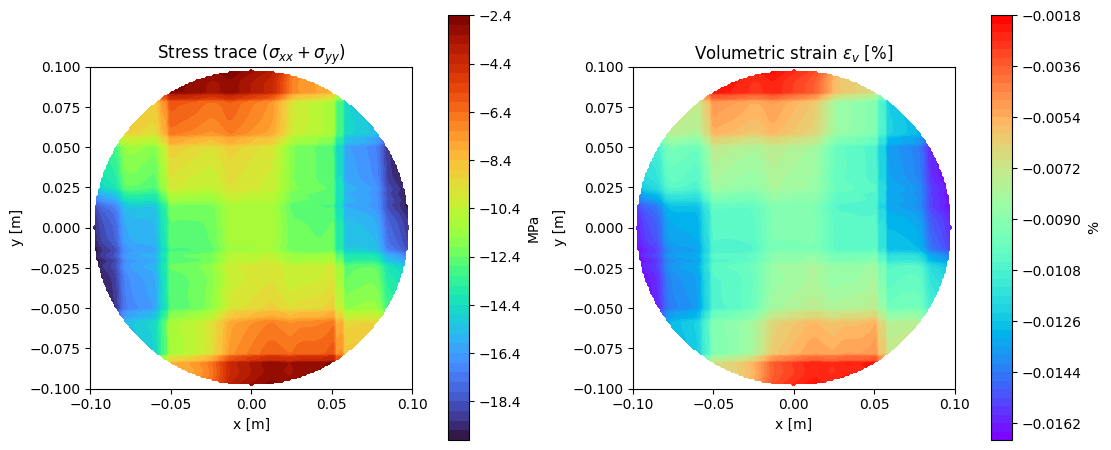

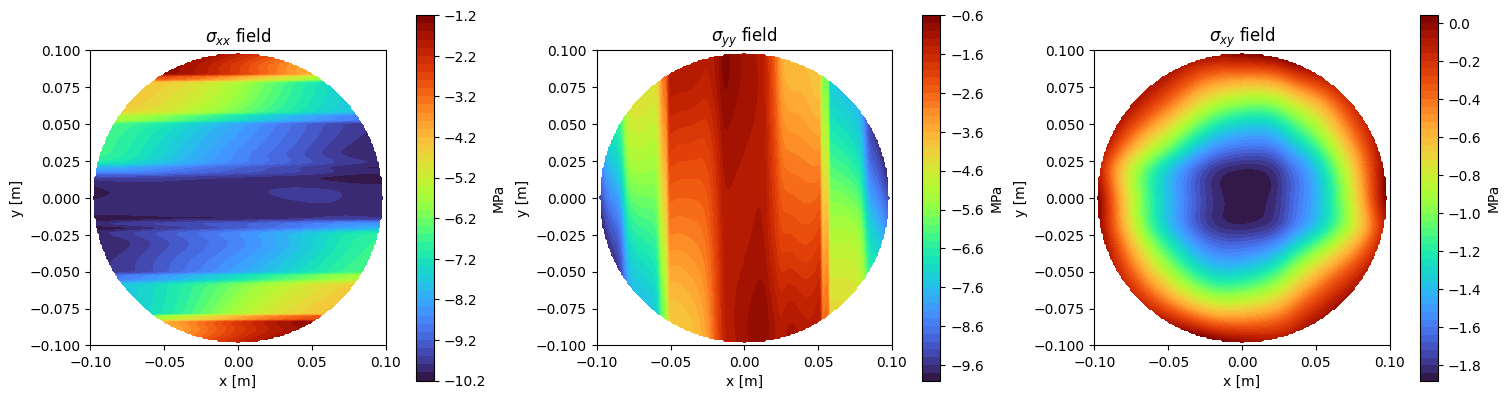

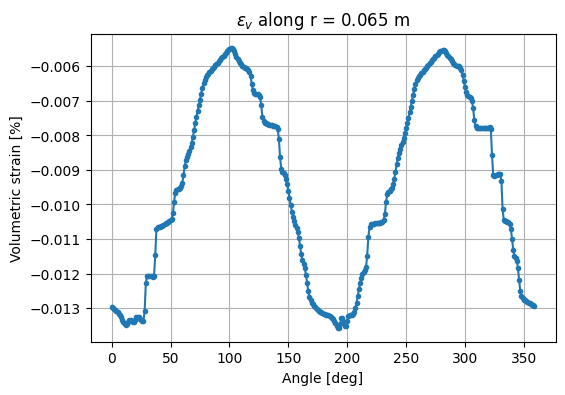

In [ ]:
# %% ------------------------------------------------------------
# Rock disk – contour maps and circumferential profile
# ------------------------------------------------------------
#  • σ_trace   = σ_xx + σ_yy
#  • ε_v       = σ_trace / 2(λ+μ)   (converted to %)
#  • Individual components σ_xx, σ_yy, σ_xy
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0. Material constants (MPa)  ── already consistent with training
# ------------------------------------------------------------
E, nu = 83.9, 0.21 # E (unit) = GPa (MPa -> GPa scale coordination is needed)
lam = E * nu / ((1 + nu) * (1 - 2 * nu))
mu  = E * 0.5 / (1 + nu)

# ------------------------------------------------------------
# 1. Cartesian grid inside outer radius R_out
# ------------------------------------------------------------
R_out  = 0.100   # plotting window
R_rock = 0.098   # trained model radius
Ngrid  = 200

x_vals = np.linspace(-R_out, R_out, Ngrid)
y_vals = np.linspace(-R_out, R_out, Ngrid)
X, Y   = np.meshgrid(x_vals, y_vals)
grid_pts = np.column_stack([X.ravel(), Y.ravel()]).astype(np.float32)

# ------------------------------------------------------------
# 2. PINN predictions on the grid
# ------------------------------------------------------------
ux, uy, sx, sy, sxy = model.predict(grid_pts).T
sigma_trace  = sx + sy

grid_sx   = sx.reshape(X.shape)
grid_sy   = sy.reshape(X.shape)
grid_sxy  = sxy.reshape(X.shape)
grid_tr   = sigma_trace.reshape(X.shape)

# mask points outside the rock disk
mask = (np.hypot(X, Y) > R_rock)
for g in (grid_sx, grid_sy, grid_sxy, grid_tr):
    g[mask] = np.nan

# ------------------------------------------------------------
# 3. Volumetric strain ε_v  [%]
# ------------------------------------------------------------
grid_ev = grid_tr / (2 * (lam + mu)) * 100 / 1e3       # percent

# ------------------------------------------------------------
# 4-A. Contour: stress trace & volumetric strain
# ------------------------------------------------------------
fig1, ax1 = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)

c1 = ax1[0].contourf(X, Y, grid_tr, 50, cmap="turbo")
fig1.colorbar(c1, ax=ax1[0], label="MPa")
ax1[0].set_title("Stress trace ($σ_{xx}+σ_{yy}$)")
ax1[0].set_xlabel("x [m]"); ax1[0].set_ylabel("y [m]"); ax1[0].set_aspect("equal")

c2 = ax1[1].contourf(X, Y, grid_ev, 50, cmap="rainbow")
fig1.colorbar(c2, ax=ax1[1], label="%")
ax1[1].set_title("Volumetric strain $ε_v$ [%]")
ax1[1].set_xlabel("x [m]"); ax1[1].set_ylabel("y [m]"); ax1[1].set_aspect("equal")

# ------------------------------------------------------------
# 4-B. Contour: individual stress components
# ------------------------------------------------------------
fig2, ax2 = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
for a, g, t in zip(ax2,
                   (grid_sx, grid_sy, grid_sxy),
                   (r"$σ_{xx}$", r"$σ_{yy}$", r"$σ_{xy}$")):
    cf = a.contourf(X, Y, g, 50, cmap="turbo")
    fig2.colorbar(cf, ax=a, label="MPa")
    a.set_title(f"{t} field")
    a.set_xlabel("x [m]")
    a.set_ylabel("y [m]")
    a.set_aspect("equal")

# ------------------------------------------------------------
# 5. Circumferential ε_v profile at r = 0.065 m
# ------------------------------------------------------------
r_sample = 0.065
theta    = np.linspace(0, 2*np.pi, 360, endpoint=False)
circle   = np.column_stack([r_sample*np.cos(theta),
                            r_sample*np.sin(theta)]).astype(np.float32)

ux_c, uy_c, sx_c, sy_c, sxy_c = model.predict(circle).T
trace_c  = sx_c + sy_c
ev_circ  = trace_c / (2 * (lam + mu)) * 100 / 1e3

plt.figure(figsize=(6, 4))
plt.plot(np.degrees(theta), ev_circ, 'o-', ms=3)
plt.xlabel("Angle [deg]"); plt.ylabel("Volumetric strain [%]")
plt.title(f"$ε_v$ along r = {r_sample:.3f} m")
plt.grid(True)

plt.show()

파이토치

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───────────────────────────────────────────────────────────────
# 0. MATERIAL CONSTANTS (dimensional)
# ----------------------------------------------------------------
E   = 83.9          # Young’s modulus (MPa)
nu  = 0.21          # Poisson’s ratio
lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))   # Lamé λ
mu   = E * 0.5 / (1 + nu)                   # Lamé μ

# ───────────────────────────────────────────────────────────────
# 1. GEOMETRY & EXTERNAL TRACTION (32 segments)
# ----------------------------------------------------------------
R_disk = 0.098  # disk radius (m)

# 16-point eccentric edge loading values (MPa)
sigma_pee_16 = np.array(
    [-10.0, -9.95, -7.80, -3.82, -1.00, -1.17, -4.46, -6.64] * 2,
    dtype=np.float32,
)
# Interpolate to 32 segments
sigma32 = np.zeros(32, dtype=np.float32)
sigma32[0::2]   = sigma_pee_16
sigma32[1:-1:2] = 0.5 * (sigma_pee_16[:-1] + sigma_pee_16[1:])
sigma32[31]     = 0.5 * (sigma_pee_16[-1] + sigma_pee_16[0])

# Compute segment start/end angles (deg)
arc_start = np.empty(32, dtype=np.float32)
arc_end   = np.empty(32, dtype=np.float32)
s = -9.375
for i in range(32):
    arc_start[i] = s
    s += 18.75 if i % 2 == 0 else 3.75
    arc_end[i] = s

# Move to torch tensors
ARC_START = torch.tensor(arc_start, device=device)
ARC_END   = torch.tensor(arc_end,   device=device)
SIGMA32   = torch.tensor(sigma32,   device=device)

# Function: normal traction σ_n(θ)
def sigma_of_angle(X: torch.Tensor) -> torch.Tensor:
    """
    X: (N,2) array of boundary points
    returns: (N,1) normal traction at each point
    """
    ang = torch.atan2(X[:,1], X[:,0]) * 180.0 / np.pi   # rad→deg
    ang = torch.where(ang < -9.375, ang + 360.0, ang)   # wrap-around
    ang = ang.unsqueeze(1)                              # shape (N,1)
    # boolean mask per segment
    cond      = (ang >= ARC_START) & (ang < ARC_END)
    cond_last = (ang >= ARC_START[-1]) & (ang <= ARC_END[-1])
    cond      = torch.cat([cond[:,:-1], cond_last], dim=1)
    return torch.sum(cond * SIGMA32, dim=1, keepdim=True)

# ───────────────────────────────────────────────────────────────
# 2. PINN NETWORK DEFINITION
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for lin in self.linears[:-1]:
            x = self.activation(lin(x))
        return self.linears[-1](x)

# Instantiate model
dim_hidden = 64
layers = [2] + [dim_hidden]*4 + [5]  # 5 hidden layers, output=5 (ux,uy,σxx,σyy,σxy)
model = PINN(layers).to(device)

# ───────────────────────────────────────────────────────────────
# 3. RESIDUAL FUNCTIONS
# ----------------------------------------------------------------
def pde_residual(xy: torch.Tensor, out: torch.Tensor):
    """
    Compute physics residuals:
      1) momentum x: ∂σxx/∂x + ∂σxy/∂y = 0
      2) momentum y: ∂σxy/∂x + ∂σyy/∂y = 0
      3) Hooke law consistency for σxx,σyy,σxy
    xy must have requires_grad=True
    out = model(xy)
    """
    ux = out[:,0:1]; uy = out[:,1:2]
    Sxx = out[:,2:3]; Syy = out[:,3:4]; Sxy = out[:,4:5]
    # Strain via autograd
    grads_ux = torch.autograd.grad(ux, xy, grad_outputs=torch.ones_like(ux), create_graph=True)[0]
    Exx = grads_ux[:,0:1]
    dux_dy = grads_ux[:,1:2]
    grads_uy = torch.autograd.grad(uy, xy, grad_outputs=torch.ones_like(uy), create_graph=True)[0]
    Eyy = grads_uy[:,1:2]
    duy_dx = grads_uy[:,0:1]
    Exy = 0.5*(dux_dy + duy_dx)
    # Hooke plane-strain
    Sxx_th = (2*mu + lmbd)*Exx + lmbd*Eyy
    Syy_th = (2*mu + lmbd)*Eyy + lmbd*Exx
    Sxy_th = 2*mu*Exy
    # Equilibrium residuals
    dSxx_dx = torch.autograd.grad(Sxx, xy, grad_outputs=torch.ones_like(Sxx), create_graph=True)[0][:,0:1]
    dSxy_dy = torch.autograd.grad(Sxy, xy, grad_outputs=torch.ones_like(Sxy), create_graph=True)[0][:,1:2]
    dSxy_dx = torch.autograd.grad(Sxy, xy, grad_outputs=torch.ones_like(Sxy), create_graph=True)[0][:,0:1]
    dSyy_dy = torch.autograd.grad(Syy, xy, grad_outputs=torch.ones_like(Syy), create_graph=True)[0][:,1:2]
    mom_x = dSxx_dx + dSxy_dy
    mom_y = dSxy_dx + dSyy_dy
    return [mom_x, mom_y, Sxx_th - Sxx, Syy_th - Syy, Sxy_th - Sxy]


def bc_residual(xy: torch.Tensor, out: torch.Tensor):
    """
    Compute traction residuals on boundary:
      tx - σ_n nx = 0, ty - σ_n ny = 0
    """
    nx = xy[:,0:1] / R_disk
    ny = xy[:,1:2] / R_disk
    Sxx = out[:,2:3]; Syy = out[:,3:4]; Sxy = out[:,4:5]
    tx = Sxx*nx + Sxy*ny
    ty = Sxy*nx + Syy*ny
    sigma_n = sigma_of_angle(xy)
    return tx - sigma_n*nx, ty - sigma_n*ny

# ───────────────────────────────────────────────────────────────
# 4. SAMPLING FUNCTIONS
# ----------------------------------------------------------------
def sample_domain(n):
    # Uniform sampling in disk via rejection or polar transform
    r = R_disk * torch.sqrt(torch.rand(n,1, device=device))
    theta = 2*np.pi * torch.rand(n,1, device=device)
    x = r * torch.cos(theta); y = r * torch.sin(theta)
    pts = torch.cat([x,y], dim=1)
    pts.requires_grad_(True)
    return pts

def sample_boundary(n):
    theta = 2*np.pi * torch.rand(n,1, device=device)
    x = R_disk * torch.cos(theta); y = R_disk * torch.sin(theta)
    pts = torch.cat([x,y], dim=1)
    pts.requires_grad_(True)
    return pts

# ───────────────────────────────────────────────────────────────
# 5. TRAINING LOOP
# ----------------------------------------------------------------
# Hyperparameters
num_domain   = 10000
num_boundary = 2000
lr           = 7.5e-4
epochs       = 30000
w_bc=5


optimizer = optim.Adam(model.parameters(), lr=lr)
pde_history, bc_history,loss_history = [], [],[]
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    # Sample points
    xy_dom = sample_domain(num_domain)
    xy_bnd = sample_boundary(num_boundary)
    # Forward pass
    out_dom = model(xy_dom)
    res_pde = pde_residual(xy_dom, out_dom)
    loss_pde = sum((r**2).mean() for r in res_pde)
    out_bnd = model(xy_bnd)
    tx_res, ty_res = bc_residual(xy_bnd, out_bnd)
    loss_bc  = tx_res.pow(2).mean() + ty_res.pow(2).mean()



    # Total loss (BC weighted ×10)
    loss = loss_pde + w_bc * loss_bc
    loss.backward()
    optimizer.step()
    # Logging
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, PDE Loss: {loss_pde.item():.3e}, BC Loss: {loss_bc.item():.3e}, Total Loss: {loss.item():.3e}")
        pde_history.append(loss_pde.item())
        bc_history.append(loss_bc.item())
        loss_history.append(loss.item())



Epoch 1000, PDE Loss: 1.801e-04, BC Loss: 5.710e+00, Total Loss: 2.855e+01
Epoch 2000, PDE Loss: 6.573e-03, BC Loss: 5.713e+00, Total Loss: 2.857e+01
Epoch 3000, PDE Loss: 2.972e-03, BC Loss: 5.657e+00, Total Loss: 2.829e+01
Epoch 4000, PDE Loss: 7.100e-04, BC Loss: 5.664e+00, Total Loss: 2.832e+01
Epoch 5000, PDE Loss: 5.620e-04, BC Loss: 5.727e+00, Total Loss: 2.864e+01
Epoch 6000, PDE Loss: 1.012e-03, BC Loss: 5.684e+00, Total Loss: 2.842e+01
Epoch 7000, PDE Loss: 3.697e-02, BC Loss: 5.708e+00, Total Loss: 2.858e+01
Epoch 8000, PDE Loss: 7.435e-01, BC Loss: 3.504e+00, Total Loss: 1.826e+01
Epoch 9000, PDE Loss: 1.274e+00, BC Loss: 3.161e+00, Total Loss: 1.708e+01
Epoch 10000, PDE Loss: 1.278e+00, BC Loss: 3.200e+00, Total Loss: 1.728e+01
Epoch 11000, PDE Loss: 1.197e+00, BC Loss: 3.086e+00, Total Loss: 1.663e+01
Epoch 12000, PDE Loss: 3.814e+00, BC Loss: 2.397e+00, Total Loss: 1.580e+01
Epoch 13000, PDE Loss: 4.278e+00, BC Loss: 1.055e+00, Total Loss: 9.552e+00
Epoch 14000, PDE Loss

시각화

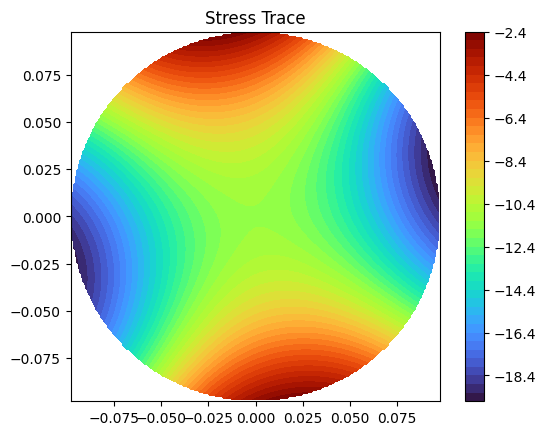

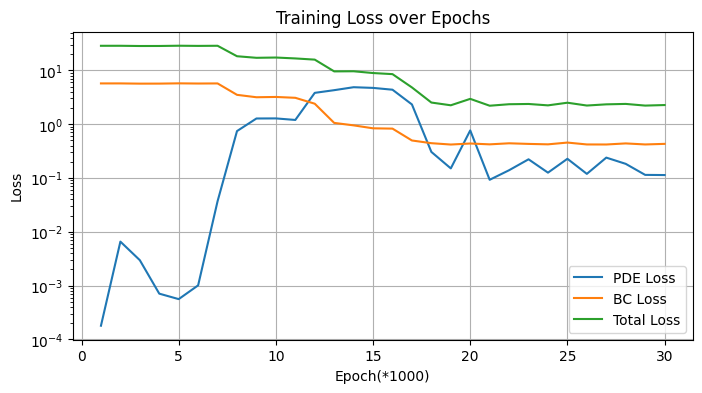

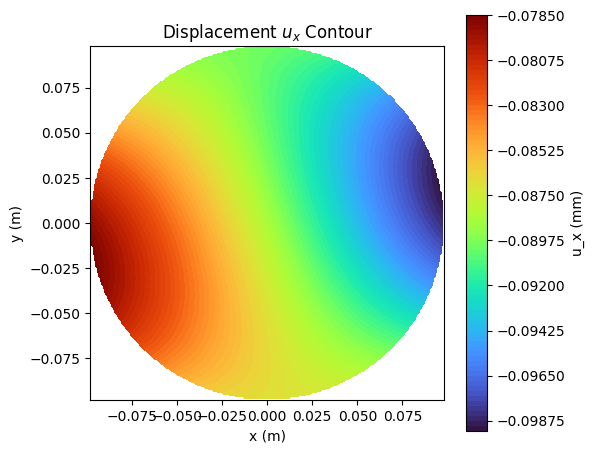

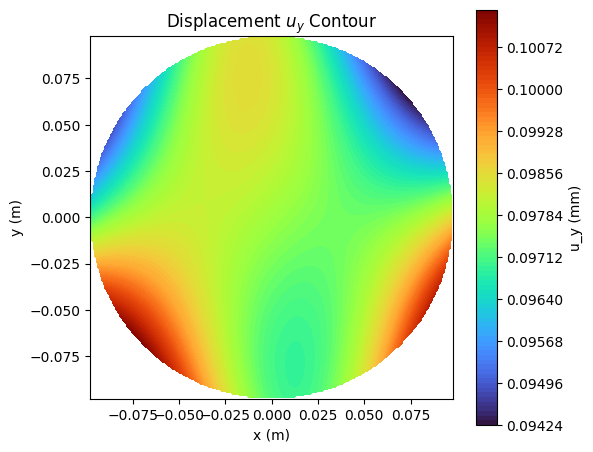

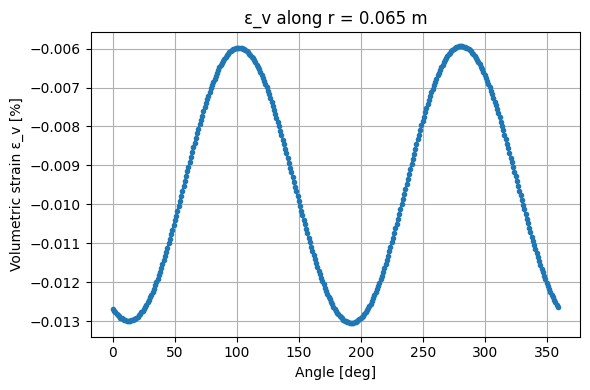

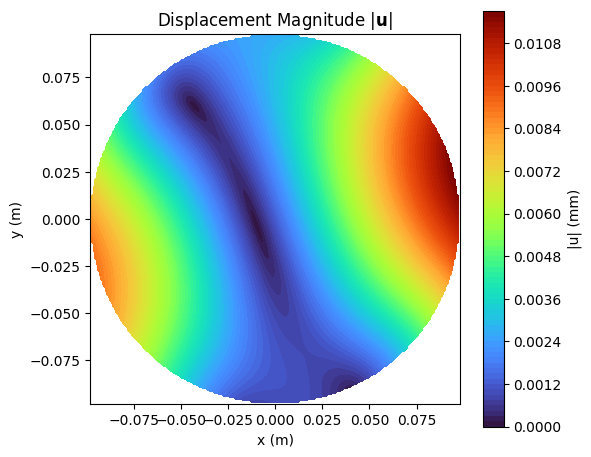

In [ ]:
# ───────────────────────────────────────────────────────────────
# 6. POST-PROCESSING & PLOTTING
# ----------------------------------------------------------------
# Example: stress trace contour map
model.eval()
Ngrid = 250
x_vals = np.linspace(-R_disk, R_disk, Ngrid)
y_vals = np.linspace(-R_disk, R_disk, Ngrid)
X, Y = np.meshgrid(x_vals, y_vals)
pts = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), device=device, dtype=torch.float32)
with torch.no_grad():
    out = model(pts)
sx = out[:,2].cpu().numpy().reshape(X.shape)
sy = out[:,3].cpu().numpy().reshape(X.shape)
trace = sx + sy
mask = np.hypot(X, Y) > R_disk
trace[mask] = np.nan
plt.figure(); plt.contourf(X, Y, trace, 50, cmap='turbo'); plt.colorbar(); plt.title('Stress Trace'); plt.gca().set_aspect('equal'); plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, epochs/1000+1), pde_history, label='PDE Loss')
plt.plot(np.arange(1, epochs/1000+1), bc_history, label='BC Loss')
plt.plot(np.arange(1, epochs/1000+1), loss_history, label='Total Loss')
plt.xlabel('Epoch(*1000)')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ───────────────────────────────────────────────────────────────
# 6-1. Displacement contour plots (ux, uy)
# ----------------------------------------------------------------
model.eval()

# 기존에 만든 그리드(X, Y)와 동일하게 사용
# pts: (Ngrid*Ngrid, 2), 안쪽/바깥쪽 마스크는 동일
pts = torch.tensor(
    np.column_stack([X.ravel(), Y.ravel()]),
    device=device, dtype=torch.float32
)

with torch.no_grad():
    out_disp = model(pts)  # 출력: [ux, uy, sxx, syy, sxy]

ux = out_disp[:, 0].detach().cpu().numpy().reshape(X.shape)
uy = out_disp[:, 1].detach().cpu().numpy().reshape(X.shape)

# 원판 바깥쪽 마스킹
mask = np.hypot(X, Y) > R_disk
ux = ux.astype(np.float64)  # NaN 대입을 위해 float64 권장
uy = uy.astype(np.float64)
ux[mask] = np.nan
uy[mask] = np.nan

# ux contour
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, ux, 100, cmap='turbo')
plt.colorbar(label='u_x (mm)')  # 단위 표기는 상황에 맞게 조정
plt.title('Displacement $u_x$ Contour')
plt.gca().set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.tight_layout()
plt.show()

# uy contour
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, uy, 100, cmap='turbo')
plt.colorbar(label='u_y (mm)')
plt.title('Displacement $u_y$ Contour')
plt.gca().set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────────
# 7. CIRCUMFERENTIAL VOLUMETRIC STRAIN (ε_v) AT r = r_sample
# ----------------------------------------------------------------
r_sample = 0.065  # [m] (must be <= R_disk)
theta = np.linspace(0, 2*np.pi, 360, endpoint=False).astype(np.float32)

# (x, y) points on the circle of radius r_sample
circle = np.column_stack([r_sample*np.cos(theta),
                          r_sample*np.sin(theta)]).astype(np.float32)

# Model inference (no gradients)
model.eval()
with torch.no_grad():
    circle_t = torch.from_numpy(circle).to(device)
    out_circ = model(circle_t)
    # outputs: [ux, uy, Sxx, Syy, Sxy]
    ux_c  = out_circ[:, 0].detach().cpu().numpy()
    uy_c  = out_circ[:, 1].detach().cpu().numpy()
    sx_c  = out_circ[:, 2].detach().cpu().numpy()
    sy_c  = out_circ[:, 3].detach().cpu().numpy()
    sxy_c = out_circ[:, 4].detach().cpu().numpy()

# Stress trace and volumetric strain (percent)
trace_c = sx_c + sy_c  # σxx + σyy  [MPa]
# NOTE: user intent kept: ε_v ≈ trace / (2*(λ+μ))
# Units: if E, λ, μ were in MPa and σ in MPa, 1e3 factor is for GPa→MPa conversion.
ev_circ = trace_c / (2.0 * (lmbd + mu)) * 100.0 / 1e3  # [%]

plt.figure(figsize=(6, 4))
plt.plot(np.degrees(theta), ev_circ, 'o-', ms=3)
plt.xlabel("Angle [deg]")
plt.ylabel("Volumetric strain ε_v [%]")
plt.title(f"ε_v along r = {r_sample:.3f} m")
plt.grid(True)
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────────
# 6-2. Displacement magnitude |u| = sqrt(ux^2 + uy^2)
# ----------------------------------------------------------------
# ux, uy는 위에서 이미 계산됨 (X, Y와 같은 shape, 원판 바깥은 NaN 처리됨)

# 단위 스케일(기본: m). mm로 보려면 1e3로 바꾸고, unit="mm"로 설정.

scale = 1; unit = "mm"   # ← 주석 해제 시 mm로 표시

u_mag = np.hypot(ux+0.08750, uy-0.09784) * scale  # sqrt(ux^2 + uy^2)

plt.figure(figsize=(6, 5))
plt.contourf(X, Y, abs(u_mag), 100, cmap='turbo')
plt.colorbar(label=f'|u| ({unit})')
plt.title('Displacement Magnitude $|\\mathbf{u}|$')
plt.gca().set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.tight_layout()
plt.show()